Load Julia packages (libraries) needed

In [1]:
using StatisticalRethinking
gr(size=(500,800))

Plots.GRBackend()

CmdStan uses a tmp directory to store the output of cmdstan

=====> /Users/rob/.julia/dev/StatisticalRethinking/notebooks/03


make: `/Users/rob/.julia/dev/StatisticalRethinking/notebooks/03/tmp/binomial' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

Calling /Users/rob/Projects/StanSupport/cmdstan/bin/stansummary to infer across chains.

Inference for Stan model: binomial_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.025, 0.025, 0.027, 0.026) seconds, 0.10 seconds total
Sampling took (0.041, 0.049, 0.042, 0.042) seconds, 0.17 seconds total

                Mean     MCSE  StdDev     5%   50%   95%    N_Eff  N_Eff/s    R_hat
lp__             -27  2.7e-02     1.1    -29   -27   -26  1.6e+03  9.1e+03  1.0e+00
accept_stat__   0.91  1.8e-03    0.13   0.63  0.96   1.0  4.7e+03  2.7e+04  1.0e+00
stepsize__      0.81  3.0e-02   0.043   0.76  0.81  0.87  2.0e+00  1.1e+01  3.8e+13
treedepth__      2.0  6.2e-02    

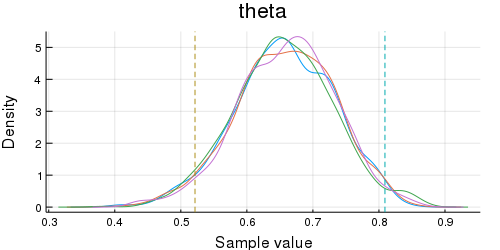

In [2]:
ProjDir = @__DIR__
cd(ProjDir) do
# Define the Stan language model
  binomialstanmodel = "
  // Inferring a Rate
  data {
    int N;
    int<lower=0> k[N];
    int<lower=1> n[N];
  }
  parameters {
    real<lower=0,upper=1> theta;
    real<lower=0,upper=1> thetaprior;
  }
  model {
    // Prior Distribution for Rate Theta
    theta ~ beta(1, 1);
    thetaprior ~ beta(1, 1);

    // Observed Counts
    k ~ binomial(n, theta);
  }
  "
# Make variables visible outisde the do loop
  global stanmodel, chn
# Define the Stanmodel and set the output format to :mcmcchain.
  stanmodel = Stanmodel(name="binomial", monitors = ["theta"], model=binomialstanmodel,
    output_format=:mcmcchain)
# Use 16 observations
    N2 = 4
    n2 = Int.(9 * ones(Int, N2))
    k2 = [6, 5, 7, 6]
# Input data for cmdstan
    binomialdata = [
      Dict("N" => length(n2), "n" => n2, "k" => k2)
    ]
# Sample using cmdstan
    rc, chn, cnames = stan(stanmodel, binomialdata, ProjDir, diagnostics=false,
      CmdStanDir=CMDSTAN_HOME)
# Describe the draws
    describe(chn)
# Look at area of hpd
    MCMCChain.hpd(chn)
# Plot the 4 chains
    if rc == 0
      mixeddensity(chn)
      bnds = MCMCChain.hpd(convert(Vector{Float64}, chn.value[:,1,1]))
      vline!([bnds[1]], line=:dash)
      vline!([bnds[2]], line=:dash)
    end

end # cd

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*